In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, plot_roc_curve, plot_precision_recall_curve

In [2]:
import config as conf
import data_preparation as pr
import features_extract as ex
import features_generator as fg

In [3]:
# DATA PREPARATION
train_events = conf.TRAIN_EVENTS
train_submissions = conf.TRAIN_SUBMISSIONS
test_events = conf.TEST_EVENTS
test_submissions = conf.TEST_SUBMISSIONS

In [4]:
# BASELINE FEATURES
# train_data =pr.data_preparation(train_events, train_submissions)
# test_data = pr.data_preparation(test_events, test_submissions)

In [ ]:
# NEW FEATURES GENERATION
train_data = fg.features_generator(train_events, train_submissions)
test_data = fg.features_generator(test_events, test_submissions)

In [33]:
# DROP FEATURES
baseline_drop = ['discovered', 'viewed', 'started_attempt', 'wrong', 'passed', 'correct']
ratio_drop = ['d_ratio', 'v_ratio', 's_ratio', 'w_ratio', 'p_ratio', 'c_ratio']
events_by_days_drop = ['d_1', 'd_2', 'v_1', 'v_2', 's_1', 's_2', 'w_1', 'w_2', 'p_1', 'p_2', 'c_1', 'c_2']
all_new_features_drop = ['d_ratio', 'v_ratio', 's_ratio', 'w_ratio', 'p_ratio', 'c_ratio', 'd_1', 'd_2', 'v_1', 'v_2', 's_1', 's_2', 'w_1', 'w_2', 'p_1', 'p_2', 'c_1', 'c_2']
custom_drop = ['d_ratio', 'v_ratio', 's_ratio', 'w_ratio', 'p_ratio', 'c_ratio', 'w_1', 'w_2', 'p_1', 'p_2', 'c_1', 'c_2', 'discovered', 'viewed', 'started_attempt',]

train_data_copy = train_data.drop(custom_drop, axis=1)
test_data_copy = test_data.drop(custom_drop, axis=1)

In [34]:
# FEATURES EXTRACTION
X, y = ex.features_extract(train_data_copy)
X_res, _ = ex.features_extract(test_data_copy)

In [35]:
# MODEL VALIDATION

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify=y)

In [37]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=2,
                            min_samples_leaf=10, min_samples_split=10,
                            class_weight='balanced')

rf.fit(X_train, y_train)
predictions_proba = rf.predict_proba(X_test)[:, 1]
predictions = rf.predict(X_test)

In [38]:
print('Log loss = {:.5f}'.format(log_loss(y_test, predictions_proba)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, predictions_proba)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, predictions_proba)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, predictions)))
print('Precision = {:.5f}'.format(precision_score(y_test, predictions)))
print('Recall = {:.5f}'.format(recall_score(y_test, predictions)))
print('F1 score = {:.5f}'.format(f1_score(y_test, predictions)))

print('\nClassification Report')
print(classification_report(y_test, predictions))

Log loss = 0.35723
AUC = 0.88241
Average Precision = 0.47104

Using 0.5 as threshold:
Accuracy = 0.78170
Precision = 0.28922
Recall = 0.77665
F1 score = 0.42149

Classification Report
              precision    recall  f1-score   support

       False       0.97      0.78      0.87      1727
        True       0.29      0.78      0.42       197

    accuracy                           0.78      1924
   macro avg       0.63      0.78      0.64      1924
weighted avg       0.90      0.78      0.82      1924



In [39]:
random_forest_cross_val = RandomForestClassifier(**rf.get_params())

cv_scores = cross_val_score(random_forest_cross_val, X, y, scoring='roc_auc', cv=10, n_jobs=-1)
mean_cv_scores = np.mean(cv_scores)
print ('mean score', mean_cv_scores)

mean score 0.8835628716492552


/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


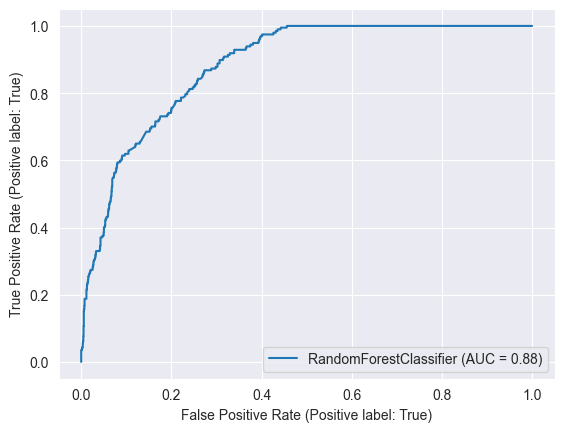

In [40]:
plot_roc_curve(rf, X_test, y_test)
plt.show()

/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


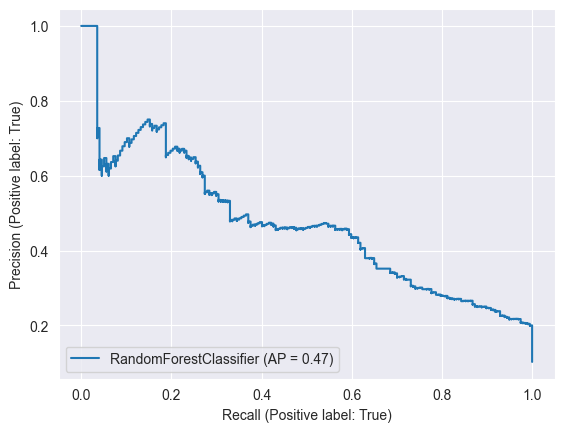

In [41]:
plot_precision_recall_curve(rf, X_test, y_test)
plt.show()

Confusion Matrix


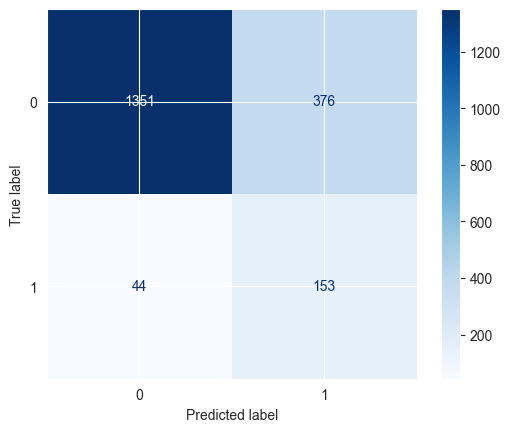

In [42]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [43]:
# PREDICTION
predictions_proba_res = rf.predict_proba(X_res)[:, 1]

In [44]:
# EXPORT DATA
result = pd.concat([pd.Series(test_data.index), pd.Series(predictions_proba_res)], axis=1).rename(columns={0: 'is_gone'}).set_index('user_id')

In [45]:
result.to_csv('/Users/mitya/prediction_res_rf.csv')

In [ ]:
# RESULT
'''
Baseline:               0.8807418373271483
Wrong, passed, correct, course_complete, d_1, d_2,
v_1, v_2, s_1, s_2:     0.886678096384541
Events by days & ratio: 0.8875785582005356
Ratio:                  0.8885695390587979
Events by days:         0.8906013200243321
'''

In [32]:
train_data.columns

Index(['discovered', 'viewed', 'started_attempt', 'wrong', 'passed', 'correct',
       'course_complete', 'd_1', 'd_2', 'v_1', 'v_2', 's_1', 's_2', 'w_1',
       'w_2', 'p_1', 'p_2', 'c_1', 'c_2', 'd_ratio', 'v_ratio', 's_ratio',
       'w_ratio', 'p_ratio', 'c_ratio'],
      dtype='object')

In [46]:
train_data_copy.columns

Index(['wrong', 'passed', 'correct', 'course_complete', 'd_1', 'd_2', 'v_1',
       'v_2', 's_1', 's_2'],
      dtype='object')